Read from mongo

In [1]:
from pymongo import MongoClient
# pprint library is used to make the output look more pretty
from pprint import pprint
# connect to MongoDB, change the << MONGODB URL >> to reflect your own connection string
client = MongoClient('localhost',27017)
db=client.admin
# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 15, 'warning': 0},
 'connections': {'active': 4,
                 'available': 999981,
                 'awaitingTopologyChanges': 3,
                 'current': 19,
                 'exhaustHello': 0,
                 'exhaustIsMaster': 2,
                 'totalCreated': 57},
 'electionMetrics': {'averageCatchUpOps': 0.0,
                     'catchUpTakeover': {'called': 0, 'successful': 0},
                     'electionTimeout': {'called': 0, 'successful': 0},
                     'freezeTimeout': {'called': 0, 'successful': 0},
                     'numCatchUps': 0,
                     'numCatchUpsAlreadyCaughtUp': 0,
                     'numCatchUpsFailedWithError': 0,
                     'numCatchUpsFailedWithNewTerm': 0,
                     'numCatchUpsFailedWithReplSetAbortPrimaryCatchUpCmd': 0,
                     'numCatchUpsSkipped': 0,
                     'numCatchUpsSucceeded': 0,
                     'nu

In [2]:
import json
db = client['Tweets_db']
collection_tweets = db['AllTweets']


In [17]:
db.AllTweets.find({"retweeted_status":{'$exists':True}}).next()

StopIteration: 

In [1]:
retweets = collection_tweets.find({"retweeted_status":{'$exists':True}})
for i in retweets:
    print(i)

NameError: name 'collection_tweets' is not defined

In [7]:
collection_tweets.find({"retweeted_status":{'$exists':True}}).count()

<ipython-input-7-c135fc65094e>:1: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  collection_tweets.find({"retweeted_status":{'$exists':True}}).count()


0

In [8]:
import sys
import json
import networkx
import optparse
import itertools
import time

from networkx import nx_pydot
from networkx.readwrite import json_graph
G = networkx.DiGraph()
optionsusers,optionshashtags,optionsretweets=False,False,True

In [9]:
def add(from_user, from_id, to_user, to_id, type, created_at=None):
    "adds a relation to the graph"
    # storing start_data will allow for timestamps for gephi timeline, where nodes will appear on screen at their start dataset
    # and stay on forever after

    if (optionsusers or optionshashtags) and to_user:
        G.add_node(from_user, screen_name=from_user, start_date=created_at)
        G.add_node(to_user, screen_name=to_user, start_date=created_at)

        if G.has_edge(from_user, to_user):
            weight = G[from_user][to_user]['weight'] + 1
        else:
            weight = 1
        G.add_edge(from_user, to_user, type=type, weight=weight)

    elif not optionsusers and to_id:
        G.add_node(from_id, screen_name=from_user, type=type)
        if to_user:
            G.add_node(to_id, screen_name=to_user)
        else:
            G.add_node(to_id)
        G.add_edge(from_id, to_id, type=type)

In [10]:
for i in retweets:
    try:
        t = json.loads(i)
# for line in open('data/myfirsttweets.jsonl'):
#     try:
#         t = json.loads(line)
    except:
        continue
    from_id = t['id_str']
    from_user = t['user']['screen_name']
    from_user_id = t['user']['id_str']
    to_user = None
    to_id = None
    # standardize raw created at date to dd/MM/yyyy HH:mm:ss
    created_at_date = time.strftime('%d/%m/%Y %H:%M:%S', time.strptime(t["created_at"],'%a %b %d %H:%M:%S +0000 %Y'))
    if optionsretweets and t.get('retweeted_status'):
            to_id = t['retweeted_status']['id_str']
            to_user = t['retweeted_status']['user']['screen_name']
            to_user_id = t['retweeted_status']['user']['id_str']
            add(from_user, from_id, to_user, to_id, "retweet")

In [11]:
networkx.write_gexf(G, 'retweetg.gexf')

Retweet graph

164

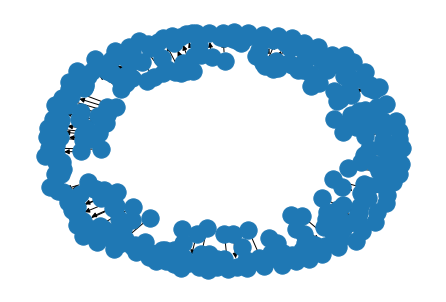

In [81]:
G = networkx.read_gexf('retweetg.gexf')
networkx.draw_spring(G)
G.number_of_edges()

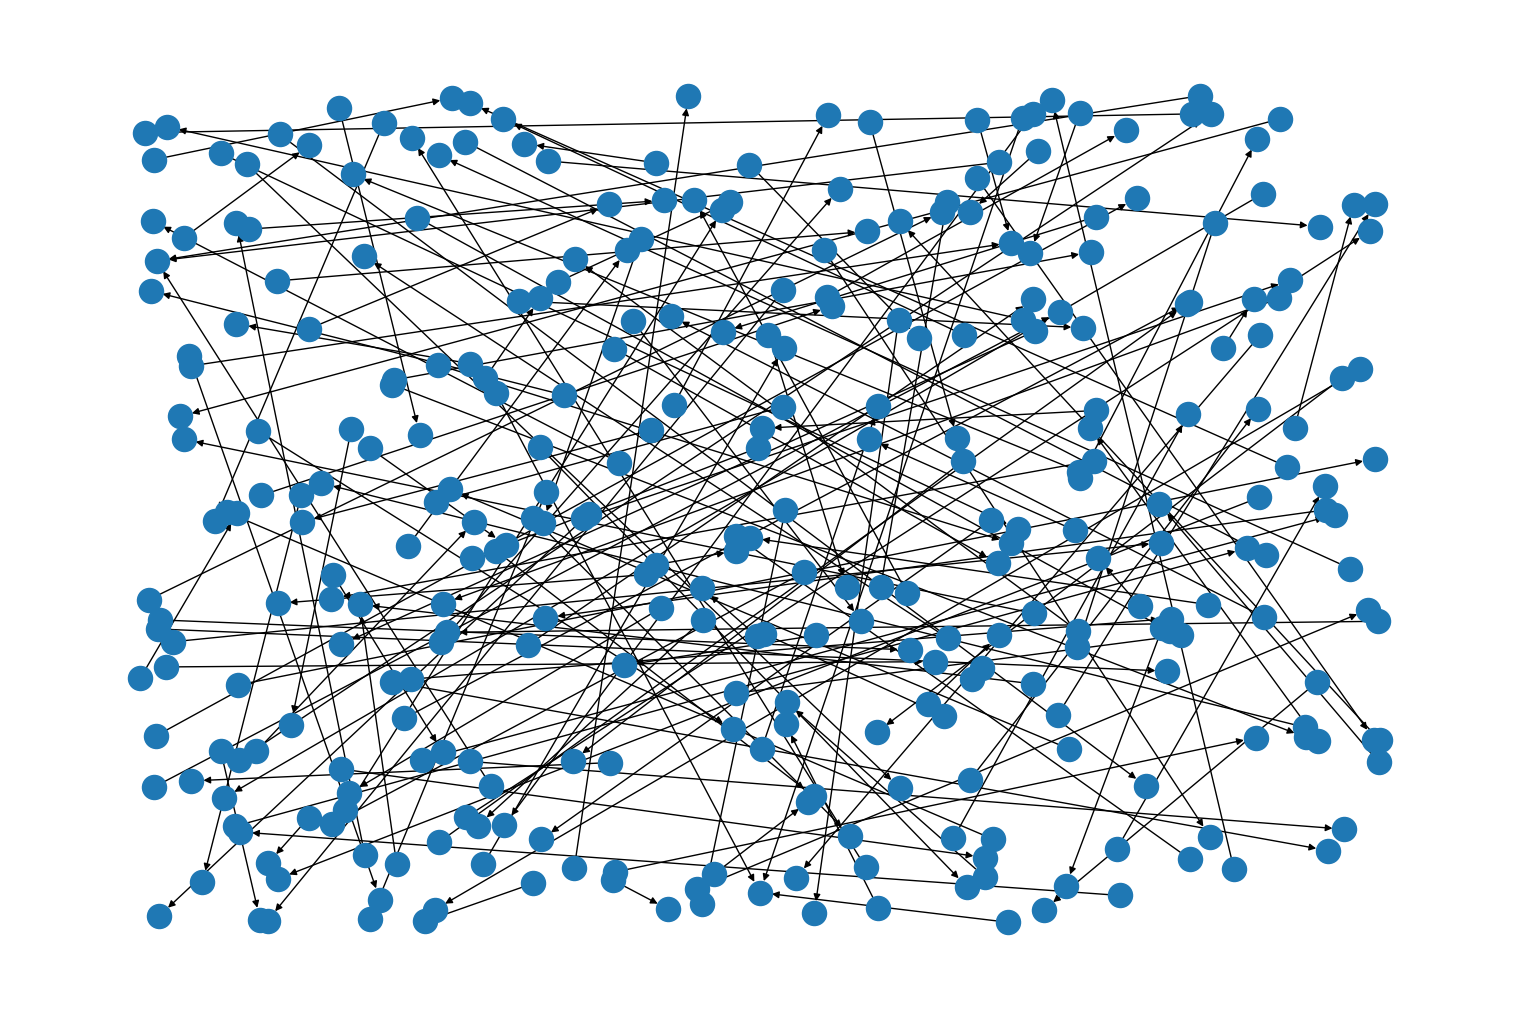

In [138]:
import matplotlib
networkx.draw_random(G)

In [139]:
from networkx.algorithms import approximation
from networkx.algorithms import community
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
# get reproducible results
import random
from numpy import random as nprand
random.seed(123)
nprand.seed(123)
kernighan = community.girvan_newman(G)


In [119]:
 def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)            

In [131]:
communities = next(kernighan)
len(communities)

159

Girvan newman

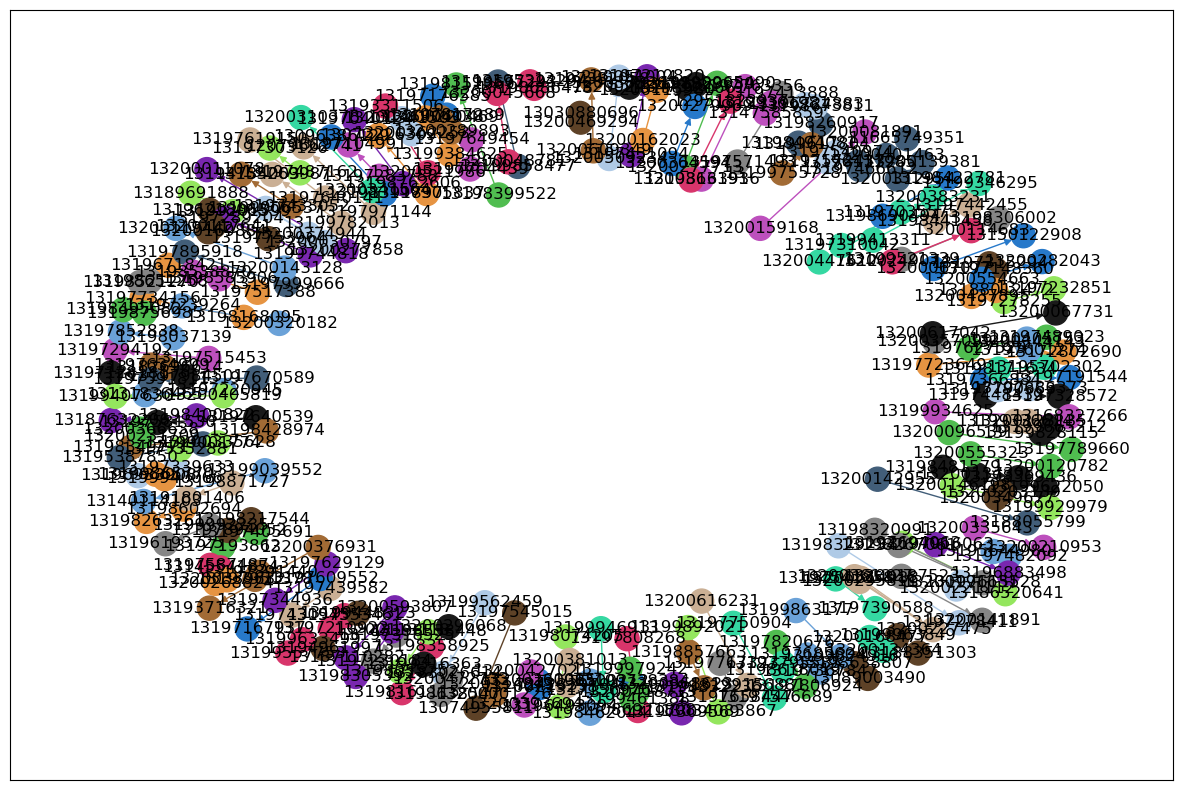

In [140]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

# Set community color for nodes
node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for internal edges
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = [get_color(G.edges[e]['community']) for e in internal]
# karate_pos = networkx.random_layout(G)
karate_pos = networkx.spring_layout(G)
# Draw external edges
networkx.draw_networkx(
    G, pos=karate_pos, node_size=0,
    edgelist=external, edge_color="#333333", with_labels=False)
# Draw nodes and internal edges
networkx.draw_networkx(
    G, pos=karate_pos, node_color=node_color,
    edgelist=internal, edge_color=internal_color)

Cliques

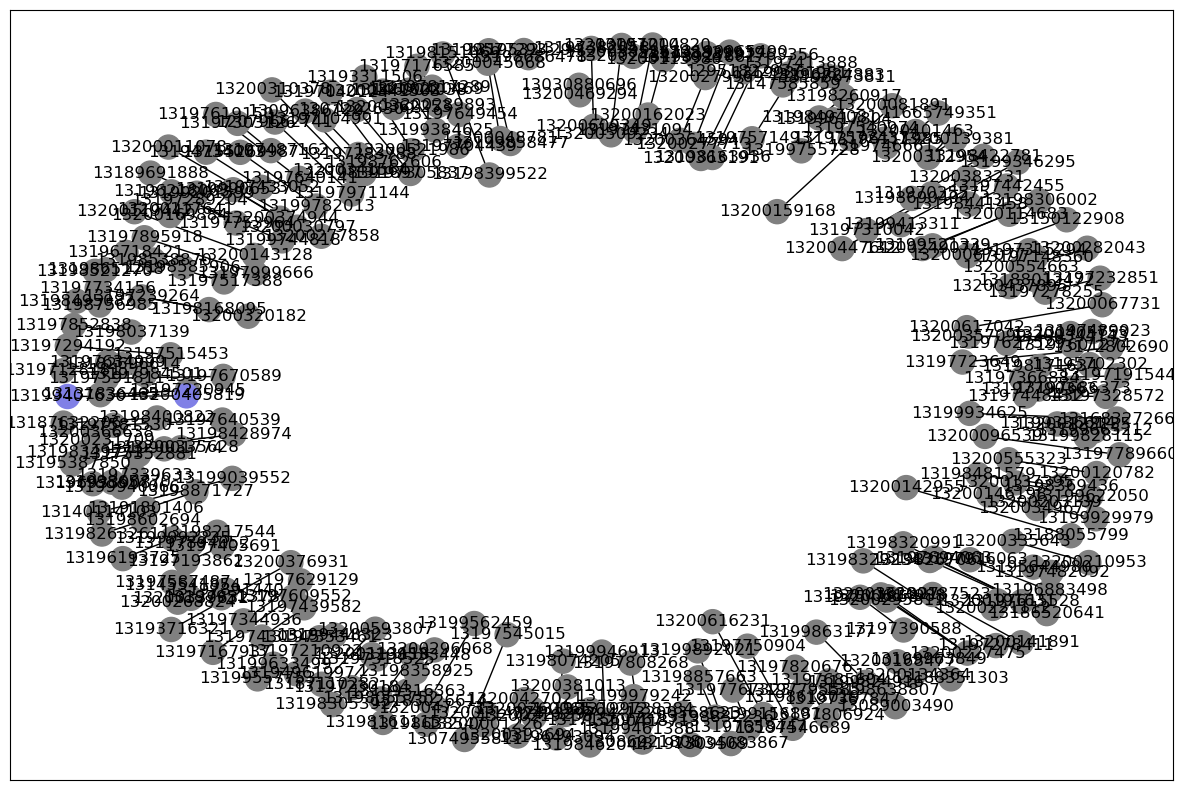

In [141]:
G_un = G.to_undirected()
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
cliques = list(networkx.find_cliques(G_un))
max_clique = max(cliques, key=len)
node_color = [(0.5, 0.5, 0.5) for v in G_un.nodes()]
for i, v in enumerate(G_un.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
networkx.draw_networkx(G_un, node_color=node_color, pos=karate_pos)

Intento de infomap

In [74]:
import matplotlib.colors as colors
import networkx
import infomap

"""
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.
"""

def findCommunities(G):
	"""
	Partition network with the Infomap algorithm.
	Annotates nodes with 'community' id and return number of communities found.
	"""
	conf = infomap.Infomap("--two-level")
	# Input data
	network = infomap.Network(conf);
	# Output data
# 	tree = infomap.tree(conf)

	print("Building network...")
	for e,v, in G.edges():
        network.addLink(e,v)
	network.finalizeAndCheckNetwork(True, nx.number_of_nodes(G))

	# Cluster network
	infomap.run(network, tree);

	print("Found %d top modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

	communities = {}
	clusterIndexLevel = 1 # 1, 2, ... or -1 for top, second, ... or lowest cluster level
	for node in tree.leafIter(clusterIndexLevel):
		communities[node.originalLeafIndex] = node.clusterIndex()

	nx.set_node_attributes(G, 'community', communities)
	return tree.numTopModules()


def drawNetwork(G):
	# position map
	pos = nx.spring_layout(G)
	# community ids
	communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
	numCommunities = max(communities) + 1
	# color map from http://colorbrewer2.org/
	cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
	cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

	# edges
	nx.draw_networkx_edges(G, pos)

	# nodes
	nodeCollection = nx.draw_networkx_nodes(G,
		pos = pos,
		node_color = communities,
		cmap = cmapLight
	)
	# set node border color to the darker shade
	darkColors = [cmapDark(v) for v in communities]
	nodeCollection.set_edgecolor(darkColors)

	# Print node labels separately instead
	for n in G.nodes_iter():
		plt.annotate(n,
			xy = pos[n],
			textcoords = 'offset points',
			horizontalalignment = 'center',
			verticalalignment = 'center',
			xytext = [0, 2],
			color = cmapDark(communities[n])
		)

	plt.axis('off')
	# plt.savefig("karate.png")
	plt.show()


G = networkx.read_gexf("retweetg.gexf")
numCommunities = findCommunities(G.to_undirected())

print("Number of communities found: %d" % numCommunities)

drawNetwork(G.to_undirected())

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-74-3f7a68feaa6d>, line 23)

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapX = infomap.Infomap("--two-level")
    
    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
#         a,b=int(e[0])+ 2**32,int(e[1])+ 2**32
        a,b=int(e[0]),int(e[1])
        print(type(a))
        infomapX.addLink(e[0],e[1])
    print("Find communities with Infomap")
    infomapX.run()

    print("Found {} modules with codelength: {}".format(infomapX.numTopModules(), infomapX.codelength()))

    communities = {}
    for node in infomapX.iterLeafNodes():
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, values=communities, name='community')

def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

G=nx.read_gexf('retweetg.gexf').to_undirected()

findCommunities(G)

drawNetwork(G)

Building Infomap network from a NetworkX graph...
<class 'int'>


TypeError: Wrong number or type of arguments for overloaded function 'InfomapWrapper_addLink'.
  Possible C/C++ prototypes are:
    infomap::InfomapWrapper::addLink(unsigned int,unsigned int,double)
    infomap::InfomapWrapper::addLink(unsigned int,unsigned int)
    infomap::InfomapWrapper::addLink(unsigned int,unsigned int,unsigned long)


In [85]:
import infomap
im = infomap.Infomap()
im.add_node(1)
im.add_node(2)
im.add_node(4)
im.add_node(3)

im.add_link(1, 2)
im.add_link(1, 3)
im.add_link(1, 4)
im.add_link(2, 4)
im.add_link(3, 4)
im.run()
im.codelength

1.9709505944546686